<a href="https://colab.research.google.com/github/pejmanS21/Covid_CT/blob/main/Covid_CT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Covid 19 Detection on CT images



# Requirements

In [1]:
#@title Download Required Libraries. { display-mode: "form" }
#@markdown **pytorch-gradcam**, **gdown**

!pip install -q -U --no-cache-dir gdown --pre
!pip install -q torchsummary
!pip install -q pytorch-gradcam 

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 6.0 MB 4.6 MB/s 


In [2]:
#@title Clone Code from GitHub. { display-mode: "form" }
#@markdown https://github.com/pejmanS21/Covid_CT.git

!git clone https://github.com/pejmanS21/Covid_CT.git

Cloning into 'Covid_CT'...
remote: Enumerating objects: 126, done.
remote: Counting objects: 100% (126/126), done.
remote: Compressing objects: 100% (76/76), done.
remote: Total 126 (delta 50), reused 118 (delta 43), pack-reused 0
Receiving objects: 100% (126/126), 3.97 MiB | 16.67 MiB/s, done.
Resolving deltas: 100% (50/50), done.


In [3]:
#@title Downloading weights from Google Drive. { display-mode: "form" }
#@markdown Preparing files and paths.

!cd /content/Covid_CT/models/ && chmod +x get_weights.sh && ./get_weights.sh
!cp -rf /content/Covid_CT/src/inc /content/

Downloading...
From: https://drive.google.com/uc?id=1PoSUIocSyi4jlFx4Dp7w3-7UcDSYA9I6
To: /content/Covid_CT/models/covid_ct_resnet_checkpoint.pth
100% 85.3M/85.3M [00:00<00:00, 92.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1PgoLOMhdmCE3HC8G_pNIPqPb4yMkQw0e
To: /content/Covid_CT/models/covid_ct_mobile_checkpoint.pth
100% 9.16M/9.16M [00:00<00:00, 58.6MB/s]


# Initial code and Settings

In [4]:
#@title Set initial settings in dictionary for better access. { display-mode: "form" }
#@markdown ```settings = init()```

import warnings
warnings.filterwarnings("ignore", category=UserWarning) 

import torch
from inc.config.utils import device, transformer, stats 
from inc.models.mobilenet import COVID_CT_MobileNet
from inc.models.resnet import COVID_CT_RESNET

def init():
    settings = {
        'DEVICE': device,
        'TRANSFORM': transformer,
        'STATS': stats,
        'RESNET_PATH': '/content/Covid_CT/models/covid_ct_resnet_checkpoint.pth',
        'MOBILE_PATH': '/content/Covid_CT/models/covid_ct_mobile_checkpoint.pth',
        'RESULTS': 'results.png',
    }

    resnet = COVID_CT_RESNET(3).to(device)
    resnet.eval()
    resnet.load_state_dict(torch.load(settings['RESNET_PATH'], map_location=settings['DEVICE']))

    mobilenet = COVID_CT_MobileNet(3).to(device)
    mobilenet.eval()
    mobilenet.load_state_dict(torch.load(settings['MOBILE_PATH'], map_location=settings['DEVICE']))
    
    settings['resnet'] = resnet
    settings['mobilenet'] = mobilenet

    return settings

settings = init()

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


  0%|          | 0.00/13.6M [00:00<?, ?B/s]

## Select model

In [5]:
#@title Set initial settings in dictionary for better access. { display-mode: "form" }

model_type = "mobilenet" #@param ["None", "mobilenet", "resnet"]
Model_Summary = False #@param {type:"boolean"}

print("Device: {}".format(settings['DEVICE']))
print("----------------------------------------------------------------")

if model_type != "None" and Model_Summary:
    settings[model_type]._summary_()


Device: cuda
----------------------------------------------------------------


# Upload and process image

Saving cap006_21.png to cap006_21.png




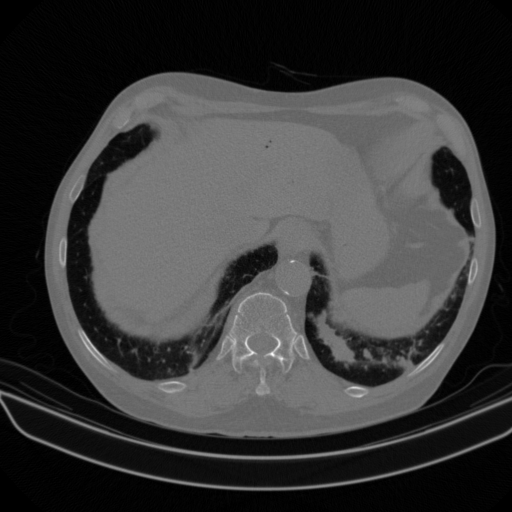

In [12]:
#@title Upload an image for Prediction. { display-mode: "form" }

from PIL import Image
from google.colab import files


uploaded = files.upload()
image = Image.open(list(uploaded.keys())[0]).convert('RGB')
print("\n")
image

In [13]:
#@title Preprocess image. { display-mode: "form" }
#@markdown `Resize` & Convert to `Tensor`

print("Convert image size from {} to (224, 224)".format(image.size))
image = settings['TRANSFORM'](image).unsqueeze(0)

print("Final image size: {}".format(image.size()))

Convert image size from (512, 512) to (224, 224)
Final image size: torch.Size([1, 3, 224, 224])


<br><br>
# Predictions

tensor(2, device='cuda:0') CAP


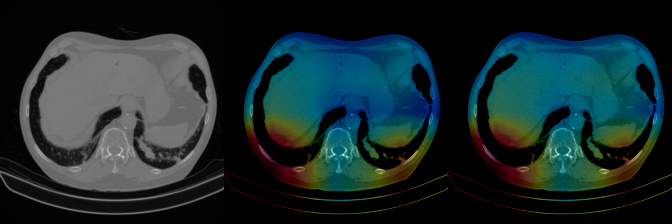

In [14]:
#@title Predictions { display-mode: "form" }

from inc.IO.grad_output import visualizer


pred, pred_name = visualizer(image.to(settings['DEVICE']), settings[model_type], model_type=model_type, result_path=settings['RESULTS'])

print(pred, pred_name)
image = Image.open(settings['RESULTS'])
image